# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


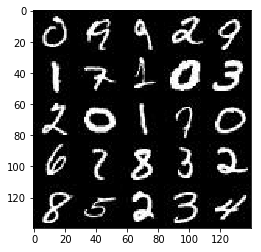

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

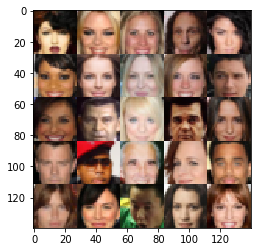

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    r_input= tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),"r_input")
    z_data = tf.placeholder(tf.float32,(None,z_dim),"z_data")
    learning_rate = tf.placeholder(tf.float32,(None),"learning_rate")
    # TODO: Implement Function

    return r_input, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/carnd/anaconda3/envs/dl/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    kernel_size=5
    strides=2
    alpha=0.2
    dropout_rate = 0.3
    filters_number = (images.get_shape()[1].value)*2
    with tf.variable_scope("discriminator",reuse=reuse):
        x1 = tf.layers.conv2d(images,filters_number,kernel_size,strides,padding="same" )
        x1 = tf.layers.dropout(inputs=x1, rate=dropout_rate,training=True)
        relu1 = tf.maximum(alpha*x1,x1)
        
        filters_number=filters_number*2
        
        x2 = tf.layers.conv2d(relu1,filters_number,kernel_size,strides,padding="same" )
        b2 = tf.layers.batch_normalization(x2,training=True)
        
        b2 = tf.layers.dropout(inputs=b2, rate=dropout_rate, training=True)
        relu2 = tf.maximum(alpha*b2,b2)
        
        filters_number=filters_number*2
        
        x3 = tf.layers.conv2d(relu2,filters_number,kernel_size,strides,padding="same" )
        b3 = tf.layers.batch_normalization(x3,training=True)
        b3 = tf.layers.dropout(inputs=b3, rate=dropout_rate, training=True)
        relu3 = tf.maximum(alpha*b3,b3)
        
        filters_number=filters_number*2
        
        x4 = tf.layers.conv2d(relu3,filters_number,kernel_size,1,padding="same" )
        b4 = tf.layers.batch_normalization(x4,training=True)
        b4 = tf.layers.dropout(inputs=b4, rate=dropout_rate, training=True)
        relu4 = tf.maximum(alpha*b4,b4)
        
        size = relu4.get_shape()[1].value*relu4.get_shape()[2].value*filters_number
       
                  
        flat = tf.reshape(relu4, (-1, size))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    if is_train==True:
        reuse=False
    else:
        reuse=True
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=reuse):
        kernel_size=5
        strides=2
        alpha=0.2
  
        x1 = tf.layers.dense(z,7*7*512,use_bias=False)
        x1 = tf.reshape(x1,(-1,7,7,512))
        b1 = tf.layers.batch_normalization(x1,training =is_train )
        o1 = tf.maximum(alpha*b1,b1)

        x2 = tf.layers.conv2d_transpose(o1,256,kernel_size,2,padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        b2 = tf.layers.batch_normalization(x2,training=is_train)
        o2 = tf.maximum(alpha*b2,b2)

        x3 = tf.layers.conv2d_transpose(o2,128,kernel_size,2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        b3 = tf.layers.batch_normalization(x3,training=is_train)
        o3 = tf.maximum(alpha*b3,b3)
        
        x4 = tf.layers.conv2d_transpose(o3,64,kernel_size,1,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        b4 = tf.layers.batch_normalization(x4,training=is_train)
        o4 = tf.maximum(alpha*b4,b4)

        logits = tf.layers.conv2d_transpose(o4,out_channel_dim,kernel_size,1,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())

        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
   

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every=10
    show_every=100
    show_n_images = 25
    samples=[]
    # TODO: Build Model
    image_channels=3 if data_image_mode=="RGB" else  1
    
    #tf.reset_default_graph()
    #print(data_shape[1],data_shape[2],image_channels, z_dim) 
    input_real, input_z,l_r = model_inputs(data_shape[1],data_shape[2],image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z,image_channels
                            )
    d_opt, g_opt = model_opt(d_loss, g_loss, l_r, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                #print(steps)
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_r:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, l_r:learning_rate})
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                        "Steps: {:d}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images , input_z, image_channels, data_image_mode)
                   
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Steps: 10... Discriminator Loss: 0.5660... Generator Loss: 4.4462
Epoch 1/2... Steps: 20... Discriminator Loss: 1.1624... Generator Loss: 3.6491
Epoch 1/2... Steps: 30... Discriminator Loss: 1.6222... Generator Loss: 3.9909
Epoch 1/2... Steps: 40... Discriminator Loss: 1.5692... Generator Loss: 2.9009
Epoch 1/2... Steps: 50... Discriminator Loss: 2.1025... Generator Loss: 2.8934
Epoch 1/2... Steps: 60... Discriminator Loss: 1.2352... Generator Loss: 1.5621
Epoch 1/2... Steps: 70... Discriminator Loss: 1.3259... Generator Loss: 1.1862
Epoch 1/2... Steps: 80... Discriminator Loss: 1.2275... Generator Loss: 1.2802
Epoch 1/2... Steps: 90... Discriminator Loss: 1.2869... Generator Loss: 1.3792
Epoch 1/2... Steps: 100... Discriminator Loss: 1.7880... Generator Loss: 0.7192


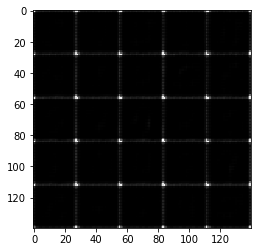

Epoch 1/2... Steps: 110... Discriminator Loss: 1.2495... Generator Loss: 1.0469
Epoch 1/2... Steps: 120... Discriminator Loss: 1.3257... Generator Loss: 1.2267
Epoch 1/2... Steps: 130... Discriminator Loss: 1.4824... Generator Loss: 0.7526
Epoch 1/2... Steps: 140... Discriminator Loss: 1.5244... Generator Loss: 1.4093
Epoch 1/2... Steps: 150... Discriminator Loss: 1.3826... Generator Loss: 1.1188
Epoch 1/2... Steps: 160... Discriminator Loss: 1.2351... Generator Loss: 1.5387
Epoch 1/2... Steps: 170... Discriminator Loss: 1.3056... Generator Loss: 0.9524
Epoch 1/2... Steps: 180... Discriminator Loss: 1.5569... Generator Loss: 1.7594
Epoch 1/2... Steps: 190... Discriminator Loss: 1.5601... Generator Loss: 1.2330
Epoch 1/2... Steps: 200... Discriminator Loss: 1.4796... Generator Loss: 0.8255


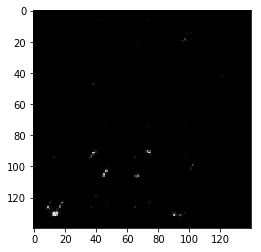

Epoch 1/2... Steps: 210... Discriminator Loss: 1.4705... Generator Loss: 0.6801
Epoch 1/2... Steps: 220... Discriminator Loss: 1.2063... Generator Loss: 1.2369
Epoch 1/2... Steps: 230... Discriminator Loss: 1.5355... Generator Loss: 0.7030
Epoch 1/2... Steps: 240... Discriminator Loss: 1.5117... Generator Loss: 0.6276
Epoch 1/2... Steps: 250... Discriminator Loss: 1.5341... Generator Loss: 0.6361
Epoch 1/2... Steps: 260... Discriminator Loss: 1.3631... Generator Loss: 1.4229
Epoch 1/2... Steps: 270... Discriminator Loss: 1.3362... Generator Loss: 1.1112
Epoch 1/2... Steps: 280... Discriminator Loss: 1.5040... Generator Loss: 0.9053
Epoch 1/2... Steps: 290... Discriminator Loss: 1.4664... Generator Loss: 1.5290
Epoch 1/2... Steps: 300... Discriminator Loss: 1.5813... Generator Loss: 0.7151


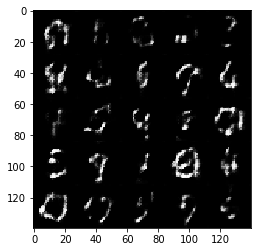

Epoch 1/2... Steps: 310... Discriminator Loss: 1.5268... Generator Loss: 1.1832
Epoch 1/2... Steps: 320... Discriminator Loss: 1.3090... Generator Loss: 0.9255
Epoch 1/2... Steps: 330... Discriminator Loss: 1.4071... Generator Loss: 0.6631
Epoch 1/2... Steps: 340... Discriminator Loss: 1.5217... Generator Loss: 1.3487
Epoch 1/2... Steps: 350... Discriminator Loss: 1.4510... Generator Loss: 1.2865
Epoch 1/2... Steps: 360... Discriminator Loss: 1.3422... Generator Loss: 0.8092
Epoch 1/2... Steps: 370... Discriminator Loss: 1.2652... Generator Loss: 0.9486
Epoch 1/2... Steps: 380... Discriminator Loss: 1.4139... Generator Loss: 1.2489
Epoch 1/2... Steps: 390... Discriminator Loss: 1.4997... Generator Loss: 1.4464
Epoch 1/2... Steps: 400... Discriminator Loss: 1.3190... Generator Loss: 0.8805


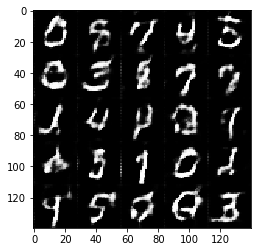

Epoch 1/2... Steps: 410... Discriminator Loss: 1.5165... Generator Loss: 0.6510
Epoch 1/2... Steps: 420... Discriminator Loss: 1.3680... Generator Loss: 0.7012
Epoch 1/2... Steps: 430... Discriminator Loss: 1.3091... Generator Loss: 0.7023
Epoch 1/2... Steps: 440... Discriminator Loss: 1.3337... Generator Loss: 0.7662
Epoch 1/2... Steps: 450... Discriminator Loss: 1.3878... Generator Loss: 0.7547
Epoch 1/2... Steps: 460... Discriminator Loss: 1.3646... Generator Loss: 1.0228
Epoch 2/2... Steps: 470... Discriminator Loss: 1.4720... Generator Loss: 1.3740
Epoch 2/2... Steps: 480... Discriminator Loss: 1.3397... Generator Loss: 1.1349
Epoch 2/2... Steps: 490... Discriminator Loss: 1.4070... Generator Loss: 1.1326
Epoch 2/2... Steps: 500... Discriminator Loss: 1.3253... Generator Loss: 0.8882


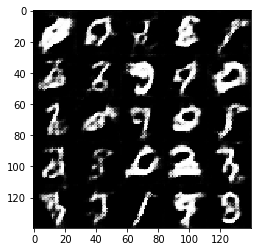

Epoch 2/2... Steps: 510... Discriminator Loss: 1.3174... Generator Loss: 0.7710
Epoch 2/2... Steps: 520... Discriminator Loss: 1.4164... Generator Loss: 0.6768
Epoch 2/2... Steps: 530... Discriminator Loss: 1.3877... Generator Loss: 0.9367
Epoch 2/2... Steps: 540... Discriminator Loss: 1.3908... Generator Loss: 0.9491
Epoch 2/2... Steps: 550... Discriminator Loss: 1.3648... Generator Loss: 0.7491
Epoch 2/2... Steps: 560... Discriminator Loss: 1.3436... Generator Loss: 1.1909
Epoch 2/2... Steps: 570... Discriminator Loss: 1.3194... Generator Loss: 0.7510
Epoch 2/2... Steps: 580... Discriminator Loss: 1.5226... Generator Loss: 0.5314
Epoch 2/2... Steps: 590... Discriminator Loss: 1.3441... Generator Loss: 1.0731
Epoch 2/2... Steps: 600... Discriminator Loss: 1.3398... Generator Loss: 1.1186


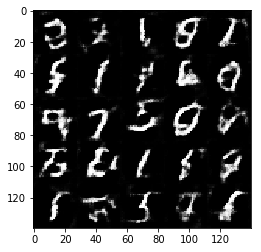

Epoch 2/2... Steps: 610... Discriminator Loss: 1.3844... Generator Loss: 0.8285
Epoch 2/2... Steps: 620... Discriminator Loss: 1.3236... Generator Loss: 0.9456
Epoch 2/2... Steps: 630... Discriminator Loss: 1.3494... Generator Loss: 0.9618
Epoch 2/2... Steps: 640... Discriminator Loss: 1.5038... Generator Loss: 1.6549
Epoch 2/2... Steps: 650... Discriminator Loss: 1.2548... Generator Loss: 0.9530
Epoch 2/2... Steps: 660... Discriminator Loss: 1.3223... Generator Loss: 1.0356
Epoch 2/2... Steps: 670... Discriminator Loss: 1.3839... Generator Loss: 0.6740
Epoch 2/2... Steps: 680... Discriminator Loss: 1.4142... Generator Loss: 0.8845
Epoch 2/2... Steps: 690... Discriminator Loss: 1.4737... Generator Loss: 0.5533
Epoch 2/2... Steps: 700... Discriminator Loss: 1.3176... Generator Loss: 1.0262


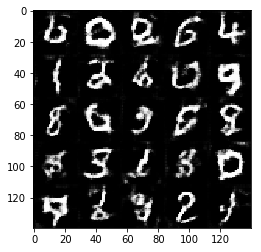

Epoch 2/2... Steps: 710... Discriminator Loss: 1.3307... Generator Loss: 1.1876
Epoch 2/2... Steps: 720... Discriminator Loss: 1.2955... Generator Loss: 1.1353
Epoch 2/2... Steps: 730... Discriminator Loss: 1.3179... Generator Loss: 0.7800
Epoch 2/2... Steps: 740... Discriminator Loss: 1.2953... Generator Loss: 1.2913
Epoch 2/2... Steps: 750... Discriminator Loss: 1.3895... Generator Loss: 0.6384
Epoch 2/2... Steps: 760... Discriminator Loss: 1.3284... Generator Loss: 1.1080
Epoch 2/2... Steps: 770... Discriminator Loss: 1.3851... Generator Loss: 0.9105
Epoch 2/2... Steps: 780... Discriminator Loss: 1.4331... Generator Loss: 0.8679
Epoch 2/2... Steps: 790... Discriminator Loss: 1.3161... Generator Loss: 1.0669
Epoch 2/2... Steps: 800... Discriminator Loss: 1.2965... Generator Loss: 0.9461


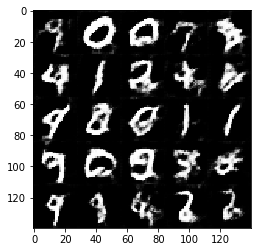

Epoch 2/2... Steps: 810... Discriminator Loss: 1.3305... Generator Loss: 0.8712
Epoch 2/2... Steps: 820... Discriminator Loss: 1.3870... Generator Loss: 1.2943
Epoch 2/2... Steps: 830... Discriminator Loss: 1.3151... Generator Loss: 0.6217
Epoch 2/2... Steps: 840... Discriminator Loss: 1.4340... Generator Loss: 1.2733
Epoch 2/2... Steps: 850... Discriminator Loss: 1.3399... Generator Loss: 0.8649
Epoch 2/2... Steps: 860... Discriminator Loss: 1.2635... Generator Loss: 1.0276
Epoch 2/2... Steps: 870... Discriminator Loss: 1.3723... Generator Loss: 0.5748
Epoch 2/2... Steps: 880... Discriminator Loss: 1.2859... Generator Loss: 0.9970
Epoch 2/2... Steps: 890... Discriminator Loss: 1.3223... Generator Loss: 0.7464
Epoch 2/2... Steps: 900... Discriminator Loss: 1.2811... Generator Loss: 0.9566


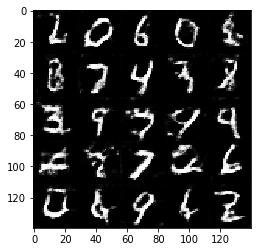

Epoch 2/2... Steps: 910... Discriminator Loss: 1.3976... Generator Loss: 0.8729
Epoch 2/2... Steps: 920... Discriminator Loss: 1.2760... Generator Loss: 1.0373
Epoch 2/2... Steps: 930... Discriminator Loss: 1.2788... Generator Loss: 1.2391


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Steps: 10... Discriminator Loss: 0.8376... Generator Loss: 1.8925
Epoch 1/1... Steps: 20... Discriminator Loss: 0.6594... Generator Loss: 3.3914
Epoch 1/1... Steps: 30... Discriminator Loss: 1.4050... Generator Loss: 1.2759
Epoch 1/1... Steps: 40... Discriminator Loss: 2.5856... Generator Loss: 0.4775
Epoch 1/1... Steps: 50... Discriminator Loss: 1.9093... Generator Loss: 1.0917
Epoch 1/1... Steps: 60... Discriminator Loss: 2.3508... Generator Loss: 0.4569
Epoch 1/1... Steps: 70... Discriminator Loss: 1.4195... Generator Loss: 1.3176
Epoch 1/1... Steps: 80... Discriminator Loss: 1.0685... Generator Loss: 1.7047
Epoch 1/1... Steps: 90... Discriminator Loss: 1.3669... Generator Loss: 1.8908
Epoch 1/1... Steps: 100... Discriminator Loss: 1.3790... Generator Loss: 0.8299


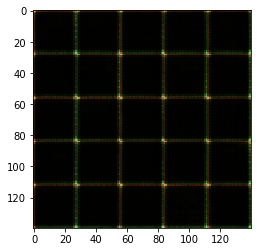

Epoch 1/1... Steps: 110... Discriminator Loss: 1.6001... Generator Loss: 3.7742
Epoch 1/1... Steps: 120... Discriminator Loss: 1.0941... Generator Loss: 2.0290
Epoch 1/1... Steps: 130... Discriminator Loss: 1.9203... Generator Loss: 0.4359
Epoch 1/1... Steps: 140... Discriminator Loss: 0.9930... Generator Loss: 2.5422
Epoch 1/1... Steps: 150... Discriminator Loss: 1.4487... Generator Loss: 0.6491
Epoch 1/1... Steps: 160... Discriminator Loss: 0.7811... Generator Loss: 2.5079
Epoch 1/1... Steps: 170... Discriminator Loss: 0.8376... Generator Loss: 2.0581
Epoch 1/1... Steps: 180... Discriminator Loss: 0.9499... Generator Loss: 1.9578
Epoch 1/1... Steps: 190... Discriminator Loss: 1.3210... Generator Loss: 0.9062
Epoch 1/1... Steps: 200... Discriminator Loss: 1.4182... Generator Loss: 2.7795


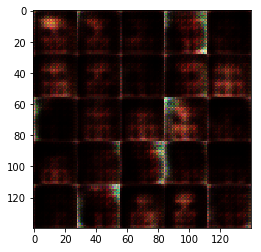

Epoch 1/1... Steps: 210... Discriminator Loss: 1.3237... Generator Loss: 0.8388
Epoch 1/1... Steps: 220... Discriminator Loss: 1.1191... Generator Loss: 1.2433
Epoch 1/1... Steps: 230... Discriminator Loss: 1.4230... Generator Loss: 0.8908
Epoch 1/1... Steps: 240... Discriminator Loss: 1.4227... Generator Loss: 1.0113
Epoch 1/1... Steps: 250... Discriminator Loss: 1.5183... Generator Loss: 1.2038
Epoch 1/1... Steps: 260... Discriminator Loss: 1.3987... Generator Loss: 1.1554
Epoch 1/1... Steps: 270... Discriminator Loss: 1.4272... Generator Loss: 1.2874
Epoch 1/1... Steps: 280... Discriminator Loss: 1.4169... Generator Loss: 1.2088
Epoch 1/1... Steps: 290... Discriminator Loss: 1.5211... Generator Loss: 1.3681
Epoch 1/1... Steps: 300... Discriminator Loss: 1.7022... Generator Loss: 0.9334


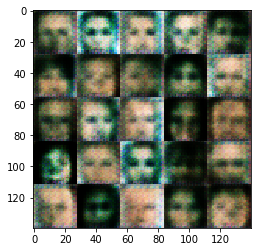

Epoch 1/1... Steps: 310... Discriminator Loss: 1.3195... Generator Loss: 1.0393
Epoch 1/1... Steps: 320... Discriminator Loss: 1.2861... Generator Loss: 1.2291
Epoch 1/1... Steps: 330... Discriminator Loss: 1.5022... Generator Loss: 0.7561
Epoch 1/1... Steps: 340... Discriminator Loss: 1.2322... Generator Loss: 1.1497
Epoch 1/1... Steps: 350... Discriminator Loss: 1.3057... Generator Loss: 0.8848
Epoch 1/1... Steps: 360... Discriminator Loss: 1.2749... Generator Loss: 1.3742
Epoch 1/1... Steps: 370... Discriminator Loss: 1.2932... Generator Loss: 1.0714
Epoch 1/1... Steps: 380... Discriminator Loss: 1.3490... Generator Loss: 1.0385
Epoch 1/1... Steps: 390... Discriminator Loss: 1.4150... Generator Loss: 0.9894
Epoch 1/1... Steps: 400... Discriminator Loss: 1.3342... Generator Loss: 2.6451


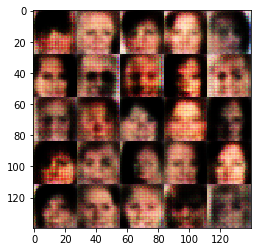

Epoch 1/1... Steps: 410... Discriminator Loss: 1.3483... Generator Loss: 1.0717
Epoch 1/1... Steps: 420... Discriminator Loss: 1.5723... Generator Loss: 0.9385
Epoch 1/1... Steps: 430... Discriminator Loss: 1.4671... Generator Loss: 0.7562
Epoch 1/1... Steps: 440... Discriminator Loss: 1.4645... Generator Loss: 1.1087
Epoch 1/1... Steps: 450... Discriminator Loss: 1.2497... Generator Loss: 0.9009
Epoch 1/1... Steps: 460... Discriminator Loss: 1.4859... Generator Loss: 1.0273
Epoch 1/1... Steps: 470... Discriminator Loss: 1.3474... Generator Loss: 1.1263
Epoch 1/1... Steps: 480... Discriminator Loss: 1.4733... Generator Loss: 0.9706
Epoch 1/1... Steps: 490... Discriminator Loss: 1.3544... Generator Loss: 0.9782
Epoch 1/1... Steps: 500... Discriminator Loss: 1.6174... Generator Loss: 0.7773


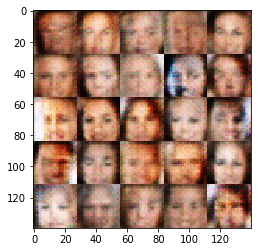

Epoch 1/1... Steps: 510... Discriminator Loss: 1.4139... Generator Loss: 0.7481
Epoch 1/1... Steps: 520... Discriminator Loss: 1.5134... Generator Loss: 1.0057
Epoch 1/1... Steps: 530... Discriminator Loss: 1.3622... Generator Loss: 0.8747
Epoch 1/1... Steps: 540... Discriminator Loss: 1.3619... Generator Loss: 0.8928
Epoch 1/1... Steps: 550... Discriminator Loss: 1.5276... Generator Loss: 1.0314
Epoch 1/1... Steps: 560... Discriminator Loss: 1.2895... Generator Loss: 0.8900
Epoch 1/1... Steps: 570... Discriminator Loss: 1.3081... Generator Loss: 0.9940
Epoch 1/1... Steps: 580... Discriminator Loss: 1.3590... Generator Loss: 0.9357
Epoch 1/1... Steps: 590... Discriminator Loss: 1.4919... Generator Loss: 0.8460
Epoch 1/1... Steps: 600... Discriminator Loss: 1.3845... Generator Loss: 0.9563


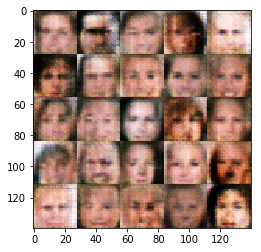

Epoch 1/1... Steps: 610... Discriminator Loss: 1.3678... Generator Loss: 0.9403
Epoch 1/1... Steps: 620... Discriminator Loss: 1.4001... Generator Loss: 0.8625
Epoch 1/1... Steps: 630... Discriminator Loss: 1.3464... Generator Loss: 0.8566
Epoch 1/1... Steps: 640... Discriminator Loss: 1.3905... Generator Loss: 1.0025
Epoch 1/1... Steps: 650... Discriminator Loss: 1.3005... Generator Loss: 0.7992
Epoch 1/1... Steps: 660... Discriminator Loss: 1.3624... Generator Loss: 0.8793
Epoch 1/1... Steps: 670... Discriminator Loss: 1.4511... Generator Loss: 1.0345
Epoch 1/1... Steps: 680... Discriminator Loss: 1.3407... Generator Loss: 0.9196
Epoch 1/1... Steps: 690... Discriminator Loss: 1.4167... Generator Loss: 0.9709
Epoch 1/1... Steps: 700... Discriminator Loss: 1.3353... Generator Loss: 0.8948


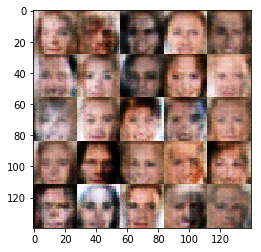

Epoch 1/1... Steps: 710... Discriminator Loss: 1.2551... Generator Loss: 0.9991
Epoch 1/1... Steps: 720... Discriminator Loss: 1.3917... Generator Loss: 0.9597
Epoch 1/1... Steps: 730... Discriminator Loss: 1.3454... Generator Loss: 1.0856
Epoch 1/1... Steps: 740... Discriminator Loss: 1.3653... Generator Loss: 0.8429
Epoch 1/1... Steps: 750... Discriminator Loss: 1.4180... Generator Loss: 0.6455
Epoch 1/1... Steps: 760... Discriminator Loss: 1.1723... Generator Loss: 2.0563
Epoch 1/1... Steps: 770... Discriminator Loss: 1.3074... Generator Loss: 0.7299
Epoch 1/1... Steps: 780... Discriminator Loss: 1.9269... Generator Loss: 0.3089
Epoch 1/1... Steps: 790... Discriminator Loss: 1.4080... Generator Loss: 0.6059
Epoch 1/1... Steps: 800... Discriminator Loss: 1.0649... Generator Loss: 0.9723


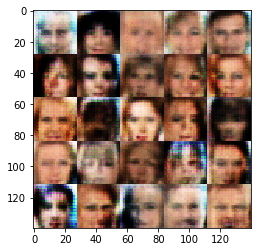

Epoch 1/1... Steps: 810... Discriminator Loss: 1.1240... Generator Loss: 0.8278
Epoch 1/1... Steps: 820... Discriminator Loss: 0.9765... Generator Loss: 1.2798
Epoch 1/1... Steps: 830... Discriminator Loss: 1.3740... Generator Loss: 1.0235
Epoch 1/1... Steps: 840... Discriminator Loss: 1.1460... Generator Loss: 0.8587
Epoch 1/1... Steps: 850... Discriminator Loss: 1.5023... Generator Loss: 0.7108
Epoch 1/1... Steps: 860... Discriminator Loss: 1.2192... Generator Loss: 1.8697
Epoch 1/1... Steps: 870... Discriminator Loss: 1.4178... Generator Loss: 0.7226
Epoch 1/1... Steps: 880... Discriminator Loss: 1.2743... Generator Loss: 1.0214
Epoch 1/1... Steps: 890... Discriminator Loss: 2.0164... Generator Loss: 2.2458
Epoch 1/1... Steps: 900... Discriminator Loss: 1.2245... Generator Loss: 0.9027


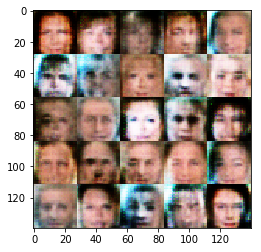

Epoch 1/1... Steps: 910... Discriminator Loss: 1.4219... Generator Loss: 0.5802
Epoch 1/1... Steps: 920... Discriminator Loss: 1.3481... Generator Loss: 2.2233
Epoch 1/1... Steps: 930... Discriminator Loss: 1.2161... Generator Loss: 0.9807
Epoch 1/1... Steps: 940... Discriminator Loss: 1.2276... Generator Loss: 0.8237
Epoch 1/1... Steps: 950... Discriminator Loss: 1.4922... Generator Loss: 0.6098
Epoch 1/1... Steps: 960... Discriminator Loss: 1.4723... Generator Loss: 0.8000
Epoch 1/1... Steps: 970... Discriminator Loss: 0.9851... Generator Loss: 1.3563
Epoch 1/1... Steps: 980... Discriminator Loss: 1.3326... Generator Loss: 0.9354
Epoch 1/1... Steps: 990... Discriminator Loss: 1.4697... Generator Loss: 0.7536
Epoch 1/1... Steps: 1000... Discriminator Loss: 0.9110... Generator Loss: 1.5230


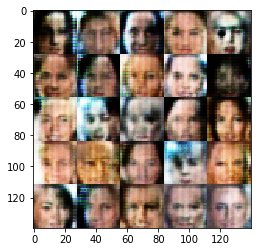

Epoch 1/1... Steps: 1010... Discriminator Loss: 1.3391... Generator Loss: 1.1366
Epoch 1/1... Steps: 1020... Discriminator Loss: 1.0851... Generator Loss: 1.3729
Epoch 1/1... Steps: 1030... Discriminator Loss: 1.2677... Generator Loss: 1.1787
Epoch 1/1... Steps: 1040... Discriminator Loss: 1.5012... Generator Loss: 1.0909
Epoch 1/1... Steps: 1050... Discriminator Loss: 1.3300... Generator Loss: 0.9205
Epoch 1/1... Steps: 1060... Discriminator Loss: 1.4071... Generator Loss: 0.8455
Epoch 1/1... Steps: 1070... Discriminator Loss: 1.4305... Generator Loss: 0.9413
Epoch 1/1... Steps: 1080... Discriminator Loss: 1.3710... Generator Loss: 1.1771
Epoch 1/1... Steps: 1090... Discriminator Loss: 1.3699... Generator Loss: 0.8964
Epoch 1/1... Steps: 1100... Discriminator Loss: 1.2640... Generator Loss: 1.0075


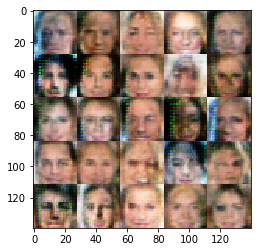

Epoch 1/1... Steps: 1110... Discriminator Loss: 1.3075... Generator Loss: 0.9579
Epoch 1/1... Steps: 1120... Discriminator Loss: 1.2033... Generator Loss: 1.0333
Epoch 1/1... Steps: 1130... Discriminator Loss: 1.1799... Generator Loss: 0.9599
Epoch 1/1... Steps: 1140... Discriminator Loss: 1.4360... Generator Loss: 0.9204
Epoch 1/1... Steps: 1150... Discriminator Loss: 1.3541... Generator Loss: 1.0283
Epoch 1/1... Steps: 1160... Discriminator Loss: 1.2369... Generator Loss: 0.7349
Epoch 1/1... Steps: 1170... Discriminator Loss: 1.3005... Generator Loss: 1.1070
Epoch 1/1... Steps: 1180... Discriminator Loss: 1.3537... Generator Loss: 0.6279
Epoch 1/1... Steps: 1190... Discriminator Loss: 1.3755... Generator Loss: 0.6117
Epoch 1/1... Steps: 1200... Discriminator Loss: 0.9470... Generator Loss: 1.5121


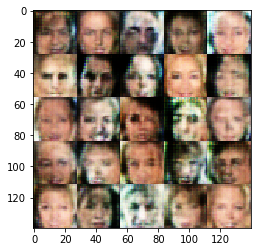

Epoch 1/1... Steps: 1210... Discriminator Loss: 1.1832... Generator Loss: 1.4765
Epoch 1/1... Steps: 1220... Discriminator Loss: 1.3644... Generator Loss: 0.9988
Epoch 1/1... Steps: 1230... Discriminator Loss: 1.0728... Generator Loss: 1.2848
Epoch 1/1... Steps: 1240... Discriminator Loss: 1.3792... Generator Loss: 1.7753
Epoch 1/1... Steps: 1250... Discriminator Loss: 1.2903... Generator Loss: 0.9857
Epoch 1/1... Steps: 1260... Discriminator Loss: 1.3161... Generator Loss: 1.1087
Epoch 1/1... Steps: 1270... Discriminator Loss: 1.4263... Generator Loss: 1.0186
Epoch 1/1... Steps: 1280... Discriminator Loss: 1.3422... Generator Loss: 1.1189
Epoch 1/1... Steps: 1290... Discriminator Loss: 1.2581... Generator Loss: 0.9121
Epoch 1/1... Steps: 1300... Discriminator Loss: 1.4080... Generator Loss: 0.6424


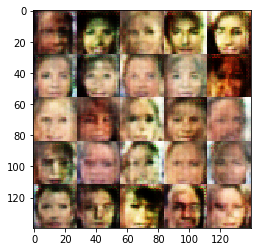

Epoch 1/1... Steps: 1310... Discriminator Loss: 1.4690... Generator Loss: 0.6993
Epoch 1/1... Steps: 1320... Discriminator Loss: 1.4701... Generator Loss: 0.4858
Epoch 1/1... Steps: 1330... Discriminator Loss: 1.3057... Generator Loss: 1.1334
Epoch 1/1... Steps: 1340... Discriminator Loss: 1.3117... Generator Loss: 0.8337
Epoch 1/1... Steps: 1350... Discriminator Loss: 1.2167... Generator Loss: 1.1962
Epoch 1/1... Steps: 1360... Discriminator Loss: 1.4429... Generator Loss: 0.6097
Epoch 1/1... Steps: 1370... Discriminator Loss: 1.3933... Generator Loss: 1.1085
Epoch 1/1... Steps: 1380... Discriminator Loss: 1.0679... Generator Loss: 1.1001
Epoch 1/1... Steps: 1390... Discriminator Loss: 1.4068... Generator Loss: 0.6308
Epoch 1/1... Steps: 1400... Discriminator Loss: 1.2464... Generator Loss: 2.1051


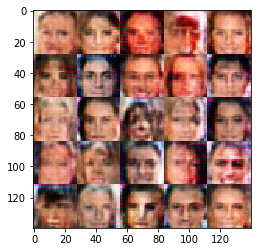

Epoch 1/1... Steps: 1410... Discriminator Loss: 1.4140... Generator Loss: 0.7320
Epoch 1/1... Steps: 1420... Discriminator Loss: 1.1911... Generator Loss: 1.0577
Epoch 1/1... Steps: 1430... Discriminator Loss: 1.2449... Generator Loss: 1.4959
Epoch 1/1... Steps: 1440... Discriminator Loss: 1.1440... Generator Loss: 1.1030
Epoch 1/1... Steps: 1450... Discriminator Loss: 1.2600... Generator Loss: 0.8858
Epoch 1/1... Steps: 1460... Discriminator Loss: 1.2805... Generator Loss: 1.3478
Epoch 1/1... Steps: 1470... Discriminator Loss: 1.0830... Generator Loss: 2.0967
Epoch 1/1... Steps: 1480... Discriminator Loss: 1.3045... Generator Loss: 1.2214
Epoch 1/1... Steps: 1490... Discriminator Loss: 1.2974... Generator Loss: 0.8733
Epoch 1/1... Steps: 1500... Discriminator Loss: 1.4087... Generator Loss: 0.6723


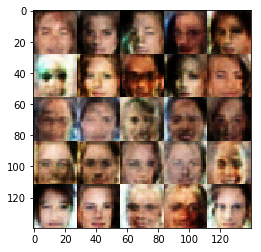

Epoch 1/1... Steps: 1510... Discriminator Loss: 1.2975... Generator Loss: 1.2951
Epoch 1/1... Steps: 1520... Discriminator Loss: 1.2001... Generator Loss: 0.9203
Epoch 1/1... Steps: 1530... Discriminator Loss: 1.3267... Generator Loss: 0.9963
Epoch 1/1... Steps: 1540... Discriminator Loss: 1.7014... Generator Loss: 0.4165
Epoch 1/1... Steps: 1550... Discriminator Loss: 1.5047... Generator Loss: 0.6513
Epoch 1/1... Steps: 1560... Discriminator Loss: 1.2937... Generator Loss: 1.3023
Epoch 1/1... Steps: 1570... Discriminator Loss: 1.4201... Generator Loss: 0.8109
Epoch 1/1... Steps: 1580... Discriminator Loss: 1.3763... Generator Loss: 0.7295


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.